# EDA ranks lasts cups

## Importing libraries

In [180]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### Reading the database

using database "international_matches.csv" from:  https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022/code That has the fifa rank scores 

In [181]:
df = pd.read_csv('data/international_matches.csv', parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df.tail()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


### Data analysis 

auxiliar function to get last registers by team in FiFA rank

In [ ]:
def get_last_register_in_FIFA(df):
    index_list=[]
    for team in df['team'].unique():
        index_list.append(df['date'][df['team']==team].idxmax())
    return df[df.index.isin(index_list)]

separating  values from home_team and away_team 

In [ ]:
home_team_features=[] 
for i,features_core in enumerate(df.iloc[:,17:].columns):
    if (i%2) == 0:
        df[features_core] = round(df.groupby('home_team')[features_core].transform(lambda x: x.fillna(x.mean())))
    else:
        df[features_core] = round(df.groupby('away_team')[features_core].transform(lambda x: x.fillna(x.mean())))

#### Fifa Rank in last FIFA date

In [ ]:
#### Top 10 attacking teams in the last FIFA date
fifa_offense = df[['date', 'home_team', 'away_team', 'home_team_mean_offense_score', 'away_team_mean_offense_score']]
home = fifa_offense[['date', 'home_team', 'home_team_mean_offense_score']].rename(columns={"home_team":"team"})
away = fifa_offense[['date', 'away_team', 'away_team_mean_offense_score']].rename(columns={"away_team":"team"})

home=get_last_register_in_FIFA(home)
away=get_last_register_in_FIFA(away)
fifa_offense=pd.merge(home[['team','home_team_mean_offense_score']],away[['team','away_team_mean_offense_score']])
fifa_offense['overall_team_mean_offense_score']=(fifa_offense['home_team_mean_offense_score']+fifa_offense['away_team_mean_offense_score'])/2

fifa_offense.sort_values(['overall_team_mean_offense_score'], ascending=False).head(10)

In [182]:
fifa_rank = df[['date','home_team','away_team','home_team_fifa_rank', 'away_team_fifa_rank']]
home = fifa_rank[['date','home_team','home_team_fifa_rank']].rename(columns={"home_team":"team","home_team_fifa_rank":"rank"})
away = fifa_rank[['date','away_team','away_team_fifa_rank']].rename(columns={"away_team":"team","away_team_fifa_rank":"rank"})
fifa_rank = pd.concat([home,away])
#Select each country latest match
fifa_rank = fifa_rank.sort_values(['team','date'],ascending=[True,False])
fifa_rank_top10 = fifa_rank.groupby('team').first().sort_values('rank',ascending=True)[0:10].reset_index()
print('Last rank')
fifa_rank_top10

Last rank


,team,date,rank
0,Brazil,2022-06-06,1
1,Belgium,2022-06-14,2
2,France,2022-06-13,3
3,Argentina,2022-06-05,4
4,England,2022-06-14,5
5,Italy,2022-06-14,6
6,Spain,2022-06-12,7
7,Portugal,2022-06-12,8
8,Mexico,2022-06-14,9
9,Netherlands,2022-06-14,10


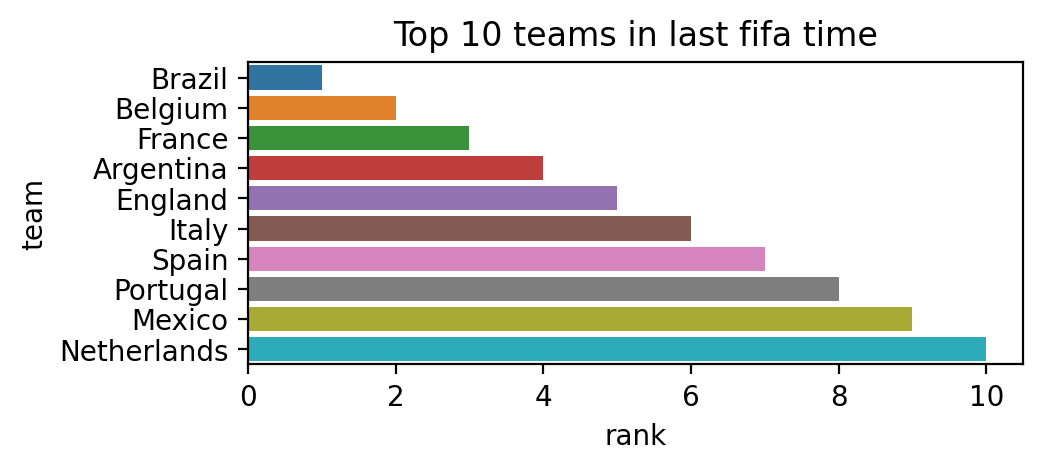

In [193]:
plt.figure(figsize=(5,2),dpi=200)
sns.barplot(data=fifa_rank_top10,y='team',x='rank')
plt.title("Top 10 teams in last fifa time");

#### Top 10 teams with the highest winning percentage at home and away


In [196]:
def home_percentage(team):
    score = len(df[(df['home_team'] == team) & (df['home_team_result'] == "Win")]) / len(df[df['home_team'] == team]) * 100
    return round(score)
def away_percentage(team):
    score = len(df[(df['away_team'] == team) & (df['home_team_result'] == "Lose")]) / len(df[df['away_team'] == team]) * 100
    return round(score)

In [197]:
fifa_rank_top10['Home_win_Per'] = np.vectorize(home_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Away_win_Per'] = np.vectorize(away_percentage)(fifa_rank_top10['team'])
fifa_rank_top10['Average_win_Per'] = round((fifa_rank_top10['Home_win_Per'] + fifa_rank_top10['Away_win_Per']) / 2)
fifa_rank_win = fifa_rank_top10.sort_values('Average_win_Per', ascending = False)
fifa_rank_win

,team,date,rank,Home_win_Per,Away_win_Per,Average_win_Per
0,Brazil,2022-06-06,1,78,60,69.0
6,Spain,2022-06-12,7,77,61,69.0
2,France,2022-06-13,3,66,57,62.0
3,Argentina,2022-06-05,4,68,49,58.0
4,England,2022-06-14,5,64,51,58.0
7,Portugal,2022-06-12,8,67,49,58.0
9,Netherlands,2022-06-14,10,62,55,58.0
5,Italy,2022-06-14,6,60,49,54.0
1,Belgium,2022-06-14,2,60,46,53.0
8,Mexico,2022-06-14,9,60,41,50.0


#### Top 10 attacking teams in the last FIFA date

In [250]:
#### Top 10 attacking teams in the last FIFA date
fifa_offense = df[['date', 'home_team', 'away_team', 'home_team_mean_offense_score', 'away_team_mean_offense_score']]
home = fifa_offense[['date', 'home_team', 'home_team_mean_offense_score']].rename(columns={"home_team":"team"})
away = fifa_offense[['date', 'away_team', 'away_team_mean_offense_score']].rename(columns={"away_team":"team"})

home=get_last_register_in_FIFA(home)
away=get_last_register_in_FIFA(away)
fifa_offense=pd.merge(home[['team','home_team_mean_offense_score']],away[['team','away_team_mean_offense_score']])
fifa_offense['overall_team_mean_offense_score']=(fifa_offense['home_team_mean_offense_score']+fifa_offense['away_team_mean_offense_score'])/2

fifa_offense.sort_values(['overall_team_mean_offense_score'], ascending=False).head(10)

,team,home_team_mean_offense_score,away_team_mean_offense_score,overall_team_mean_offense_score
84,Argentina,89.0,89.0,89.0
196,England,88.0,88.0,88.0
175,France,88.0,88.0,88.0
124,Portugal,86.0,86.0,86.0
110,Belgium,86.0,86.0,86.0
32,Brazil,86.0,86.0,86.0
199,Poland,85.0,85.0,85.0
156,Spain,85.0,85.0,85.0
96,Italy,85.0,85.0,85.0
152,Uruguay,84.0,84.0,84.0


### Data pre-processing 

incidence of Nan values 

date                                 0
home_team                            0
away_team                            0
home_team_continent                  0
away_team_continent                  0
home_team_fifa_rank                  0
away_team_fifa_rank                  0
home_team_total_fifa_points          0
away_team_total_fifa_points          0
home_team_score                      0
away_team_score                      0
tournament                           0
city                                 0
country                              0
neutral_location                     0
shoot_out                            0
home_team_result                     0
home_team_goalkeeper_score       15542
away_team_goalkeeper_score       15826
home_team_mean_defense_score     16134
home_team_mean_offense_score     15411
home_team_mean_midfield_score    15759
away_team_mean_defense_score     16357
away_team_mean_offense_score     15609
away_team_mean_midfield_score    15942
dtype: int64

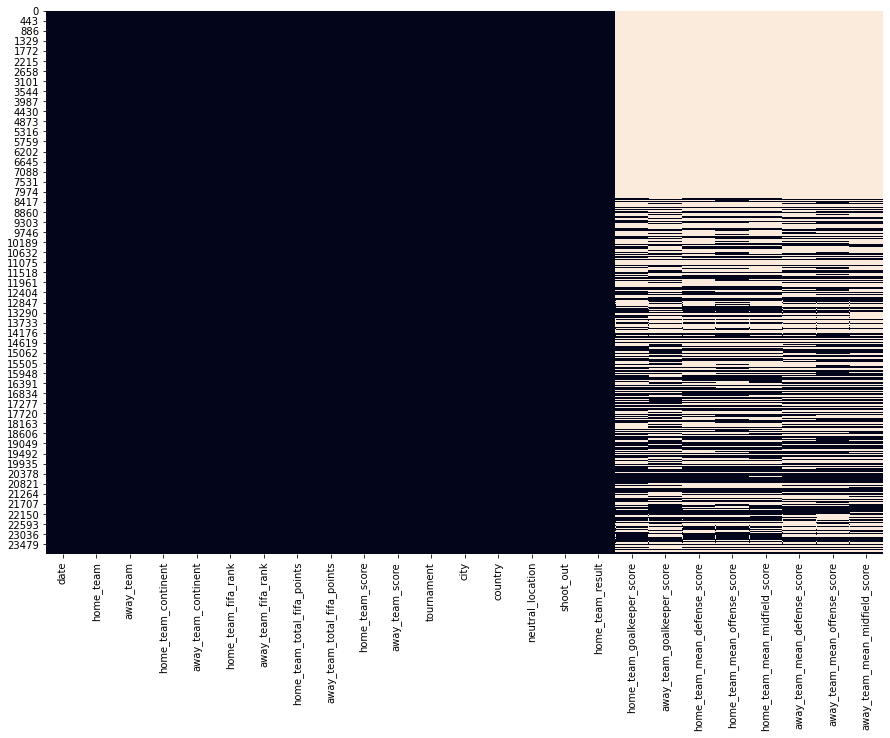

In [183]:
plt.figure(figsize=(15,10))
sns.heatmap(df.isnull(), cbar = False);
df.isnull().sum()


fill mean values in the Nan 

In [184]:
# fill mean for na's values in dataset
df.iloc[:,17:].describe()

,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
count,8379.000000,8095.000000,7787.000000,8510.000000,8162.000000,7564.000000,8312.000000,7979.000000
mean,74.963838,74.212477,74.903249,75.818743,75.889292,74.424379,75.420019,75.259143
std,8.212242,8.225919,6.003114,6.268416,6.053110,5.937425,6.201906,6.124573
min,47.000000,47.000000,52.800000,53.300000,54.200000,52.800000,53.300000,54.200000
25%,70.000000,69.000000,71.000000,71.700000,72.500000,70.500000,71.300000,71.800000
50%,75.000000,74.000000,75.200000,75.700000,76.200000,74.500000,75.300000,75.500000
75%,81.000000,80.000000,78.800000,80.000000,79.500000,78.200000,79.700000,79.000000
max,97.000000,97.000000,91.800000,93.000000,93.200000,91.800000,93.000000,93.200000


In [185]:
df.iloc[:,17:].columns

Index(['home_team_goalkeeper_score', 'away_team_goalkeeper_score',
       'home_team_mean_defense_score', 'home_team_mean_offense_score',
       'home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')

In [186]:
home_team_features=[] 
for i,features_core in enumerate(df.iloc[:,17:].columns):
    if (i%2) == 0:
        df[features_core] = round(df.groupby('home_team')[features_core].transform(lambda x: x.fillna(x.mean())))
    else:
        df[features_core] = round(df.groupby('away_team')[features_core].transform(lambda x: x.fillna(x.mean())))


In [187]:
df.isnull().sum()

date                                0
home_team                           0
away_team                           0
home_team_continent                 0
away_team_continent                 0
home_team_fifa_rank                 0
away_team_fifa_rank                 0
home_team_total_fifa_points         0
away_team_total_fifa_points         0
home_team_score                     0
away_team_score                     0
tournament                          0
city                                0
country                             0
neutral_location                    0
shoot_out                           0
home_team_result                    0
home_team_goalkeeper_score       5683
away_team_goalkeeper_score       6254
home_team_mean_defense_score     8019
home_team_mean_offense_score      175
home_team_mean_midfield_score    6955
away_team_mean_defense_score     8285
away_team_mean_offense_score      191
away_team_mean_midfield_score    7036
dtype: int64

In [178]:
# Teams are not available in FIFA game itself, so they are not less than average performing teams, so giving a average score of 20 for all.
df.fillna(20,inplace=True)

### Filter the teams participating in QATAR - World cup 2022
